<div style=float:right><img src="assets/img/appliedai-logo.png" width=100 style="margin: 0px 20px"></img></div>


##### Jonathan Sedar Personal Project
## PyMC3 vs PyStan Comparison
_Spring 2016_

This set of Notebooks and scripts comprise the **pymc3_vs_pystan** personal project by Jonathan Sedar of Applied AI Ltd, written primarily for presentation at the PyData London 2016 Conference.

The project demonstrates hierarchical linear regression using two Bayesian inference frameworks: PyMC3 and PyStan. The project borrows heavily from code written for Applied AI Ltd and is supplied here for educational purposes only. No copyright or license is extended to users.



    
# 20_InitialDataAnalysis

#### Visualisation, Investigative Modelling
    
    
+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Load Data](#Load-Data)


+ [1D and 2D Distributions](#1D-and-2D-Distributions)
    + [Restate Assumptions](#Restate-Assumptions)
    + [Simple Counts and Distributions](#Simple-Counts-and-Distributions)
    + [NOx Emissions](#NOx-Emissions)


+ [t-SNE Representation](#t-SNE-Representation)


# Setup

In [1]:
## Interactive magics
%matplotlib inline
%qtconsole --colors=linux

In [2]:
# general packages
import sqlite3
from convenience_functions import *
from ipywidgets import interactive, fixed

# scientific packages
import numpy as np
import pandas as pd
import patsy as pt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# formatting etc
sns.set(style="darkgrid", palette="muted")
pd.set_option('display.mpl_style', 'default')
# plt.style.use('default')
plt.rcParams['figure.figsize'] = 12, 6
np.random.seed(0)

## Local Functions

In [3]:
def plot_tsne(dftsne, ft_num, ft_hue='mfr_is_vw'):
    """ customised scatterplot for t-sne representation """
   
    pal = 'cubehelix' 
    leg = True

    if ft_endog in ft_num:
        pal = 'BuPu'
        leg = False
    
    g = sns.lmplot('x', 'y', dftsne.sort_values(by=ft_hue), hue=ft_hue, palette=pal
                   ,fit_reg=False, size=9, legend=leg
                   ,scatter_kws={'alpha':0.7,'s':100, 'edgecolor':'w', 'lw':0.4})
    _ = g.axes.flat[0].set_title('t-SNE rep colored by {}'.format(ft_hue))


## Load Data

In [4]:
cnxsql = sqlite3.connect('data/car_emissions.db')
df = pd.read_sql('select * from cars', cnxsql, index_col=None)

In [5]:
## convert sqlite bool storage (as ints) back to bools
for ft in ['parent_is_vw','mfr_is_vw','is_tdi']:
    df[ft] = df[ft].astype(bool)

In [6]:
custom_describe(df)

(2643, 18)


,2607,1653,835,count,mean,std,min,25%,50%,75%,max,dtype
mfr,volvo,mercedes-benz,bmw,2643,NaN,NaN,abarth,NaN,NaN,NaN,volvo,object
model,"v60, my16","c-class saloon, model year 2015",7 series f01/f02,2643,NaN,NaN,1 seri,NaN,NaN,NaN,zafira,object
desc,d4 cross country,"c 220 bluetec with 18"" rear wheels",730d saloon,2643,NaN,NaN,'1 air,NaN,NaN,NaN,zc 1.6,object
fuel_type,diesel,diesel,diesel,2643,NaN,NaN,diesel,NaN,NaN,NaN,petrol,object
metric_combined,4.6,4.1,5.6,2643,5.65,1.87,3.1,4.4,5.1,6.3,16,float64
metric_extra_urban,4.2,3.6,5.1,2643,4.85,2.35,0,4.0,4.5,5.3,107,float64
metric_urban_cold,5.3,4.9,6.5,2643,7.10,3.00,0,5.2,6.2,8.1,24.7,float64
engine_capacity,1969,2143,2993,2643,2073.12,903.98,395,1560.0,1984.0,1999.0,6752,float64
emissions_co_mgkm,268,278,223,2643,268.21,140.57,30,162.0,243.0,341.0,913,float64
emissions_nox_mgkm,24,62,46,2643,37.40,18.63,1,23.0,35.0,52.0,158,float64


##### Declare feats for use

In [7]:
fts_cat_few = ['parent_is_vw','mfr_is_vw','trans','fuel_type','is_tdi']
fts_cat_many = ['parent','mfr']
fts_num = ['metric_combined','metric_extra_urban','metric_urban_cold'
           ,'engine_capacity','emissions_co_mgkm']
ft_endog = 'emissions_nox_mgkm'

---

# 1D and 2D Distributions

## Restate Assumptions

We want to see if VW displays unusual patterns in NOx emissions compared to the rest of the manufacturers, esp with respect to Diesel TDI engines.

+ `emissions_nox_mgkm`

... according to a handful of exogenous variables:

+ `manufacturer, transmission, fuel_type, is_tdi`
+ `engine_capacity, metric_combined, metric_extra_urban, metric_urban_cold`


## Simple Counts and Distributions

##### Count plots of Categorial feats (few levels)

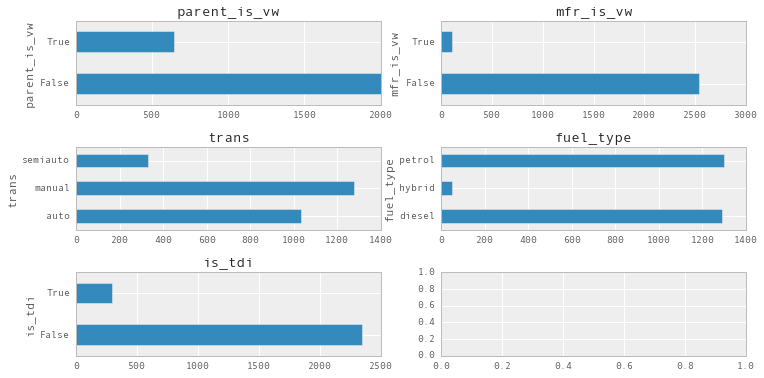

In [9]:
f, ax2d = plt.subplots(3,2, squeeze=False, figsize=(12,6))
for i, ft in enumerate(fts_cat_few):
    _ = df.groupby(ft).size().plot(kind='barh', ax=ax2d[i//2, i%2], title=ft)

**Observe:**

+ The `parent_is_vw` class is surprisingly almost balanced: Volkswagen group own a lot of subsidiary brands inc Audi, Bentley, Lamborghini, Porsche, Seat, Skoda, and of course, Volkswagen.
+ We might be wary of `fuel_type` and `is_tdi` which are quite unbalanced

##### Count plots of Categorial feats (many levels)

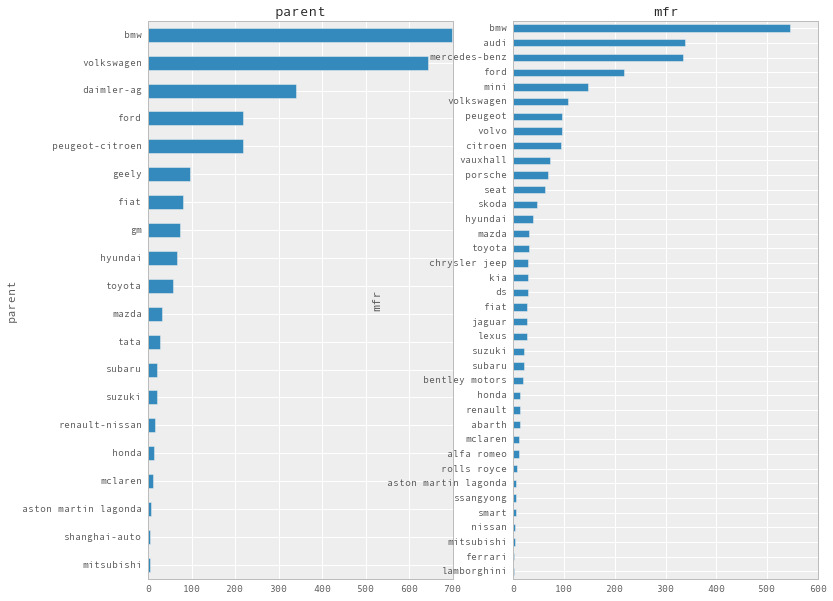

In [12]:
f, ax2d = plt.subplots(1,2, squeeze=False, figsize=(12,10))
for i, ft in enumerate(fts_cat_many):
    _ = df.groupby(ft).size().sort_values().plot(kind='barh', ax=ax2d[i//2, i%2], title=ft)

**Observe:**

+ Parent class is quite imbalanced: majority `volkswagen` and `bmw`
+ Mfr class is also quite imbalanced and sparse: some mfrs are really under-represented
+ This is course, why we might want to consider pooled models...

##### View the parent-manufacturer hierarchy

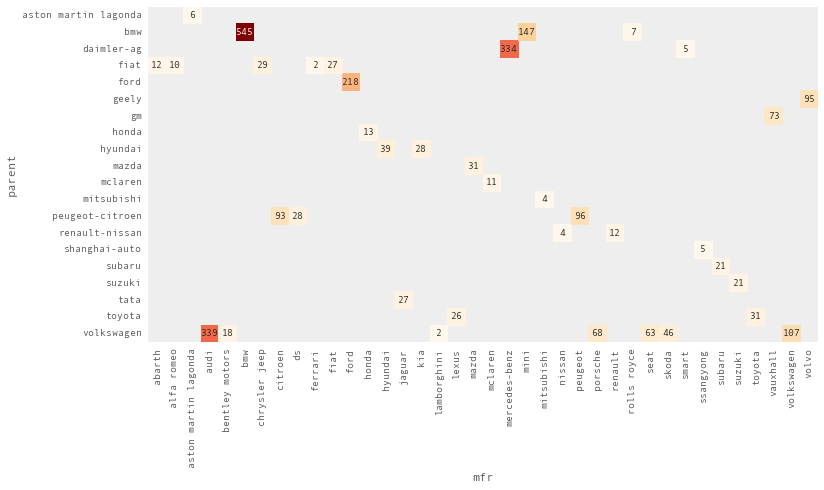

In [13]:
f, ax1d = plt.subplots(1,1,figsize=(12,6))
ax = sns.heatmap(df.groupby(['parent','mfr']).size().unstack()
    ,annot=True, fmt='.0f', cbar=False, ax=ax1d, cmap='OrRd')

**Observe:**

+ Some `mfr` levels which are otherwise very under-represented are collected into larger `parent` levels. Hopefully useful


##### Histograms of Numeric feats

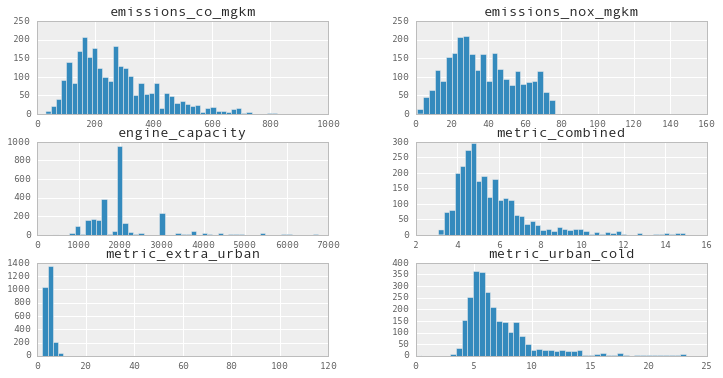

In [14]:
ax = df[fts_num+[ft_endog]].hist(bins=50, figsize=(12,2*3))

**Observe**

+ The emissions features look reasonably well distributed
    + `emissions_nox_mgkm` is our endog (output) feature and it looks smooth, albeit some outliers at the far r.h.s.
+ The `engine_capacity` looks sparse with some high outliers on r.h.s, likely very high-powered cars. Least-squares models may get adversely affected by this.
+ The `metric_*` features all seem to have the same distribution: perhaps, as their names suggest, they're connected? Let's take a look...

##### Pairs-plots of `metric_*` features

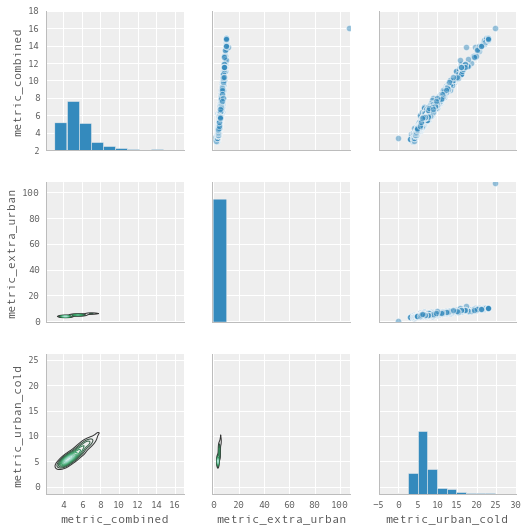

In [15]:
g = sns.PairGrid(df[['metric_combined','metric_extra_urban','metric_urban_cold']])
_ = g.map_upper(plt.scatter, linewidths=1, edgecolor="w", s=40, alpha=0.5)
_ = g.map_diag(plt.hist)
_ = g.map_lower(sns.kdeplot)

**Observe**

+ Yes, these three features all appear to be corrolated: quite strongly in fact.
+ We will have to account for this in the modelling - which assumes features are independent (orthogonal).

## Distributions of Features w.r.t Emissions NOx

`pandas` and `seaborn` make comparitive plotting very easy, so lets take a look at how the original features vary vs the exogneous feature `emissions_nox_mgkm`

##### Categorical feats (few levels)

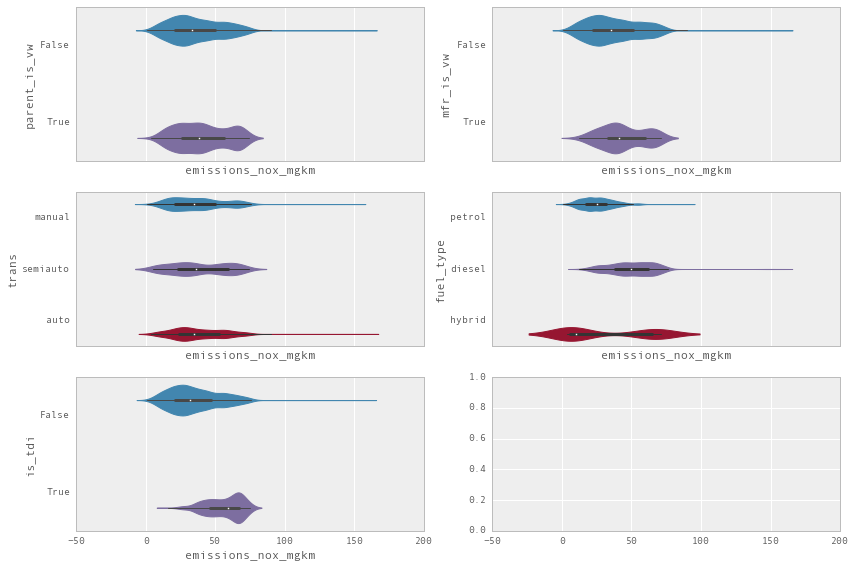

In [16]:
col_wrap = 2
f, ax2d = plt.subplots(nrows=int(np.ceil(len(fts_cat_few)/col_wrap)), ncols=col_wrap
                       ,squeeze=False, sharey=False, sharex=True, figsize=(12,8))

for i, ft in enumerate(fts_cat_few):
    ax = sns.violinplot(x=ft_endog, y=ft, data=df, hue=ft, ax=ax2d[i//col_wrap,i%col_wrap]
                    ,saturation=0.8, orient='h')
    ax.legend().set_visible(False) 

plt.tight_layout()

**Observe:**

+ `parent_is_vw` appears to have a slightly higher distribution for the endogenous feature `emissions_nox_mgkm`
+ `trans` appears fairly mixed: the value `auto` has a wider variance than `manual` and `semiauto`
+ `fuel_type` is quite interesting: we ought to expect `diesel` engines to emit more NOx, but there's still some outlying `petrol` engines that are high emitters. The `hybrid` class appears bimodal, so we may have to split this out or ignore it in future modelling
+ Similarly, we see that `is_tdi` == True engines have markedly higher emissions. This parameter is dependent upon, and correlated with `fuel_type == diesel`, so again, we would have to be careful with any assumptions of linear independence.

##### Categorical feats (many levels)

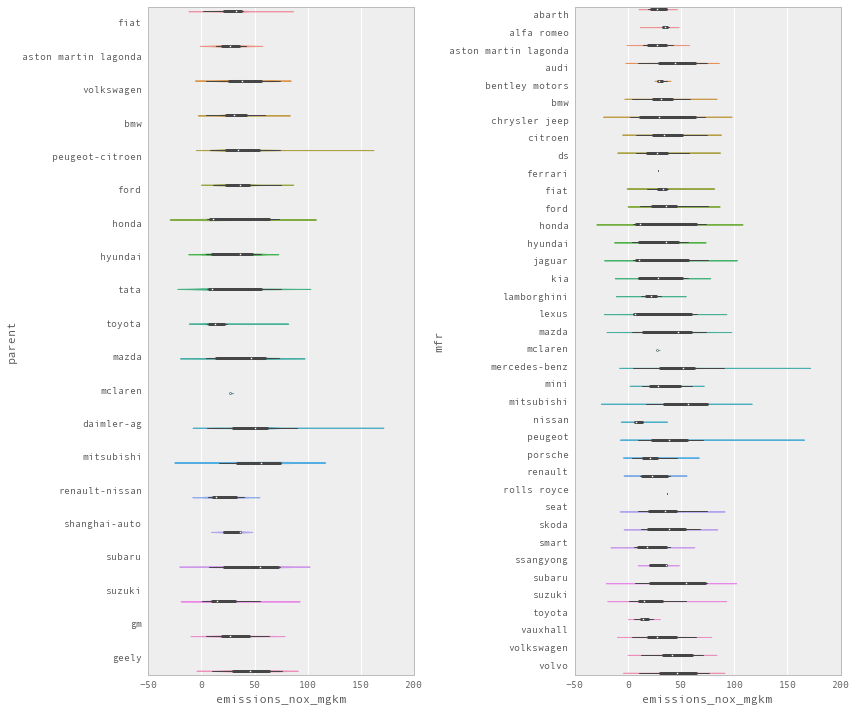

In [17]:
col_wrap = 2
f, ax2d = plt.subplots(nrows=int(np.ceil(len(fts_cat_many)/col_wrap)), ncols=col_wrap
                       ,squeeze=False, sharey=False, sharex=True, figsize=(12,10))

for i, ft in enumerate(fts_cat_many):
    ax = sns.violinplot(x=ft_endog, y=ft, data=df, hue=ft, ax=ax2d[i//col_wrap,i%col_wrap]
                    ,saturation=0.8, orient='h')
    ax.legend().set_visible(False) 

plt.tight_layout()

##### Look at MacLaren

In [19]:
df.loc[df['parent']=='mclaren',['model','desc']]

,model,desc
1493,"mclaren 625c, my2015",coupé (625 ps) sports muffler
1494,"mclaren 625c, my2015",coupé (625 ps) standard muffler
1495,"mclaren 625c, my2015",spider (625 ps) sports muffler
1496,"mclaren 625c, my2015",spider (625 ps) standard muffler
1497,"mclaren 650s le mans, my2015",coupé (650 ps) sports muffler
1498,"mclaren 650s le mans, my2015",coupé (650 ps) standard muffler
1499,"mclaren 650s, my2015",coupé (650 ps) sports muffler
1500,"mclaren 650s, my2015",coupé (650 ps) standard muffler
1501,"mclaren 650s, my2015",spider (650 ps) sports muffler
1502,"mclaren 650s, my2015",spider (650 ps) standard muffler


##### Numeric feats

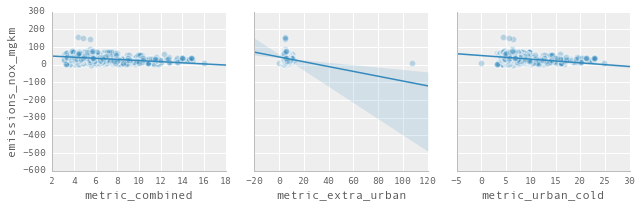

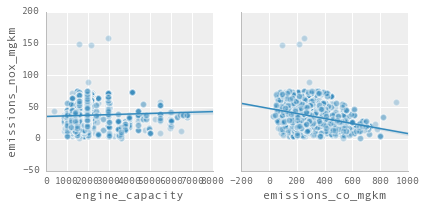

In [20]:
ax = sns.pairplot(df, x_vars=fts_num[:3], y_vars=[ft_endog]
            ,size=3, aspect=1, kind="reg"
            ,plot_kws={'scatter_kws':{'alpha':0.3, 's':40, 'lw':1.5, 'edgecolor':'w'}})

ax = sns.pairplot(df, x_vars=fts_num[3:], y_vars=[ft_endog]
            ,size=3, aspect=1, kind="reg"
            ,plot_kws={'scatter_kws':{'alpha':0.3, 's':40, 'lw':1.5, 'edgecolor':'w'}})

**Observe:**

+ I've used `seaborn`'s `fit_reg` function, which fits and plots and very basic OLS for each fact of the `pairplot`
+ There appears to be some correlation with `emissions_nox_mgkm` across all the numeric features, so we ought to at least see something interesting from the linear models

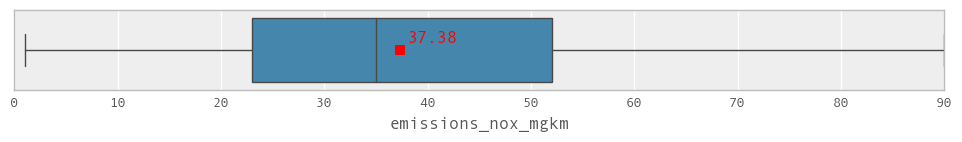

In [70]:
f, ax1d = plt.subplots(1,1,figsize=(12,1))
ax = sns.boxplot(df[ft_endog], showmeans=True, sym='', ax=ax1d)
_ = ax.annotate('{:.2f}'.format(df[ft_endog].mean()), color='r', fontsize=12
                ,xy=(df[ft_endog].mean(),0), xycoords='data'
                ,xytext=(5,5), textcoords='offset points')

**Observe:**

+ Overall NOx emissions are mean 37.41, median 35

> Lets look at the split by manufacturer:

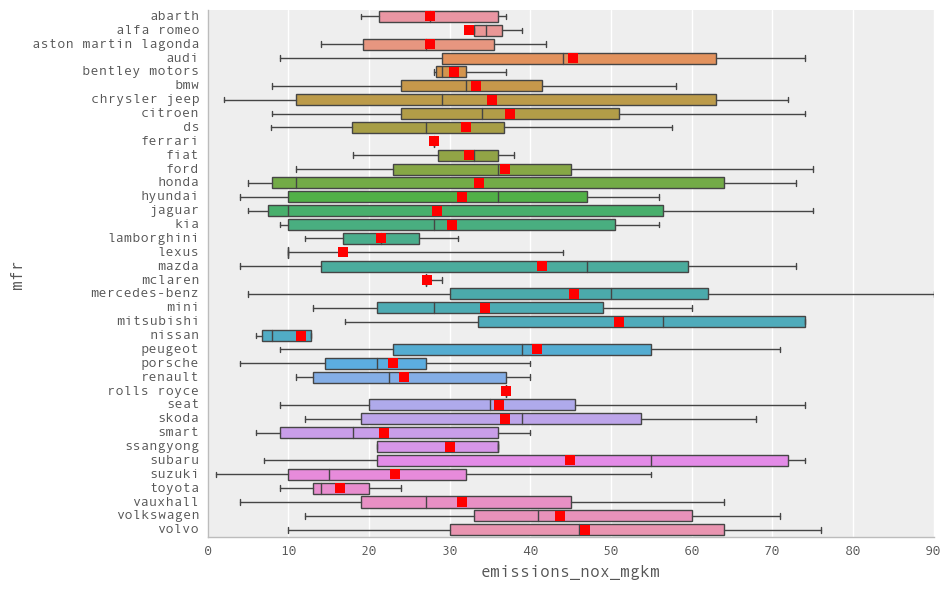

In [71]:
g = sns.factorplot(x=ft_endog, y='mfr'
        ,data= df.loc[df['fuel_type'].isin(['petrol','diesel'])]
        ,kind='box', aspect=1.6, size=6, showmeans=True, sym='')

**Observe:**

+ Volkswagen does appear to be relatively high, nearly 75% falls within the global top 50%

> How does this split by fuel type?

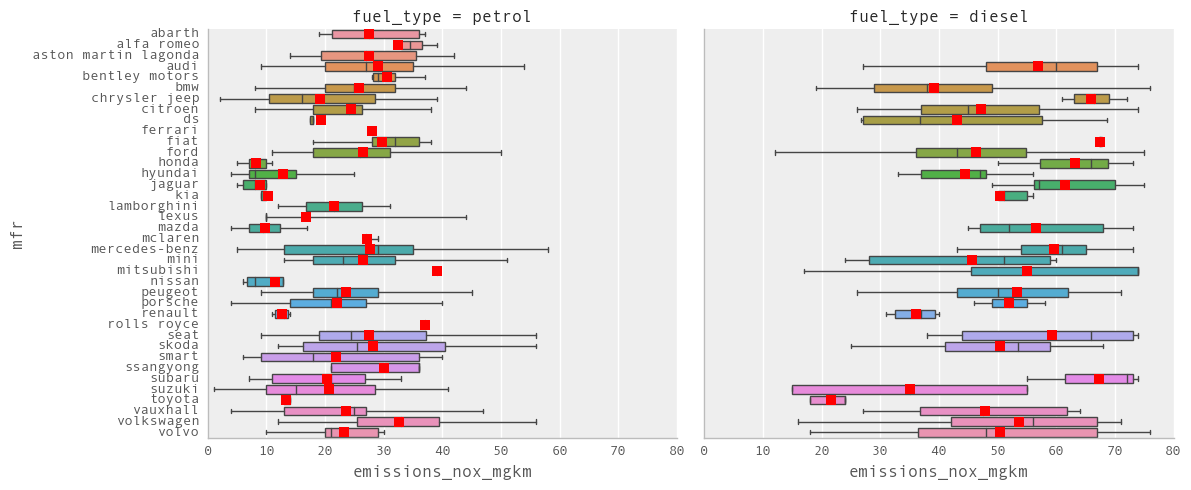

In [72]:
g = sns.factorplot(x=ft_endog, y='mfr', col='fuel_type'
                   ,data= df.loc[df['fuel_type'].isin(['petrol','diesel'])]
                   ,kind='box', aspect=1.2, size=5, showmeans=True, sym='')

**Observe:**

+ Volkswagen appears middle to low for diesel. Very high for petrol

> can we split further to see the effect of TDi?

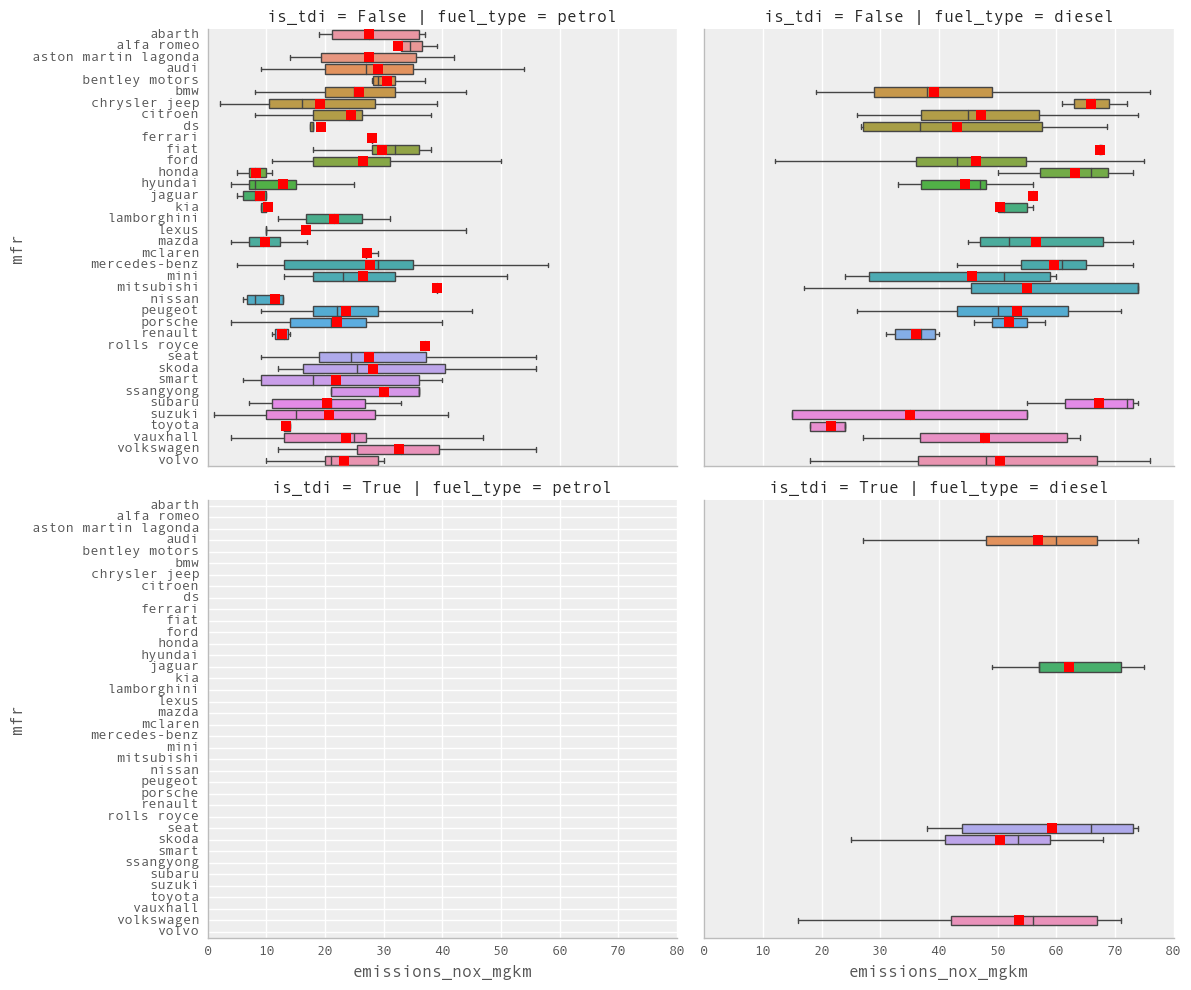

In [73]:
g = sns.factorplot(x=ft_endog, y='mfr', col='fuel_type', row='is_tdi'
                   ,data= df.loc[df['fuel_type'].isin(['petrol', 'diesel'])]
                   ,kind='box', aspect=1.2, size=5, showmeans=True, sym='')

**Observe:**

+ Volkswagen TDi would appear to kick out more NOx emissions than their regular diesel cars

> How about transmission?

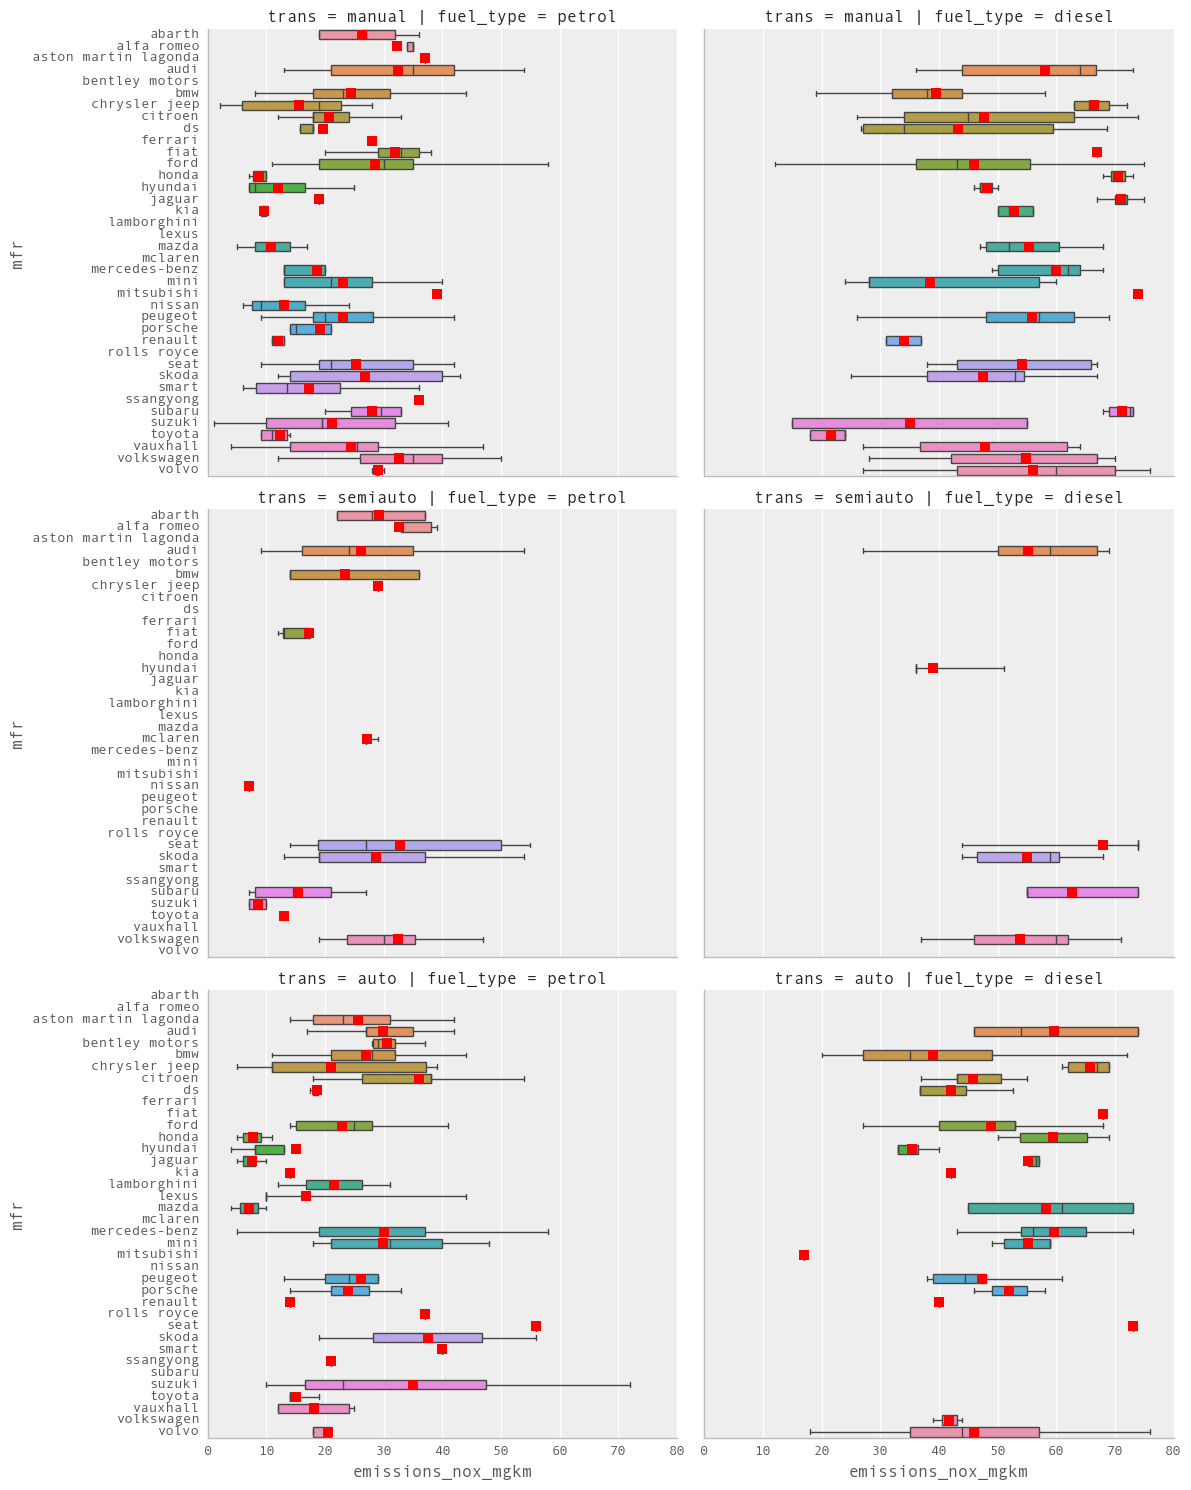

In [74]:
g = sns.factorplot(x=ft_endog, y='mfr', col='fuel_type', row='trans'
                   ,data= df.loc[df['fuel_type'].isin(['petrol', 'diesel'])]
                   ,kind='box', aspect=1.2, size=5, showmeans=True, sym='')

**Observe:**

+ Volkswagen looks high for manual (petrol and diesel), average for semi auto, note that all semiauto diesels seem quite high, and low-middle for auto (petrol and diesel)

> This is interesting but clearly starting to get out of hand, lets try reducing the instances (outlier removal) and reducing features (feature selection) for data visualisation and modelling

# t-SNE Representation

Run on numeric feats, view manufacturer categorical: clustering indicates separability

As I detailed in one of my [previous blogposts on t-SNE](), this is a technique for non-linear feature reduction: taking datapoints in Nd space and representing them in a 2d manifold. 

We then scatterplot this 2d representation and optionally add color to show the distribution of other categorial or numeric features throughout the feature space.

Clusters and denisty patterns are interesting and let us learn more about the separability of the data, and what type of machine learning models (discriminative, generative etc) might be suitable for use.

Note: only the exogenous numeric features are used to create the t-SNE manifold: `'metric_combined','metric_extra_urban','metric_urban_cold','engine_capacity','emissions_co_mgkm'`

In [75]:
# tSNE using Barnes-Hut method in scikit-learn 0.17
tsne = TSNE(n_components=2, random_state=0)
%time Z = tsne.fit_transform(df[fts_num])

CPU times: user 30.9 s, sys: 4.53 s, total: 35.5 s
Wall time: 37.3 s


In [76]:
dftsne = pd.DataFrame(Z, columns=['x','y'], index=df.index)
dftsne[fts_cat] = df[fts_cat]
dftsne[fts_num] = df[fts_num]
dftsne[ft_endog] = df[ft_endog]

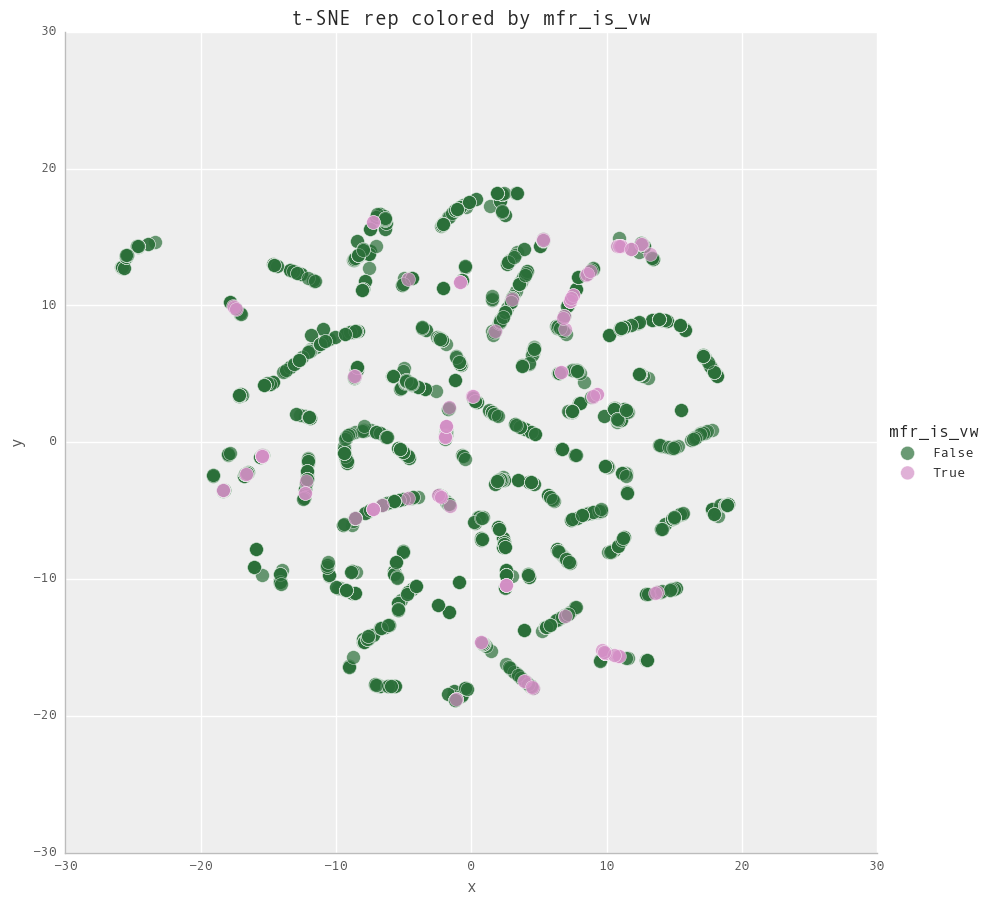

In [77]:
interactive(plot_tsne, dftsne=fixed(dftsne), ft_num=fixed(fts_num)
                ,ft_hue=fts_cat+fts_num)

**Observe:**

+ The general pattern of the t-SNE representation is quite homogeneous, indicating we have a good spread of numeric values
+ The default overlay feature shown above is `mfr_owner_is_vw`, which appears to be distributed throughout the space in a slightly 'clumpy' manner: heavy in some clusters, light or absent in others. 
+ This indicates that if we were seeking to classify cars according to `mfr_owner_is_vw`, then a simple GLM might not be most appropriate: perhaps a higher dimensional discriminative model like a Decision Tree or SVM would work.

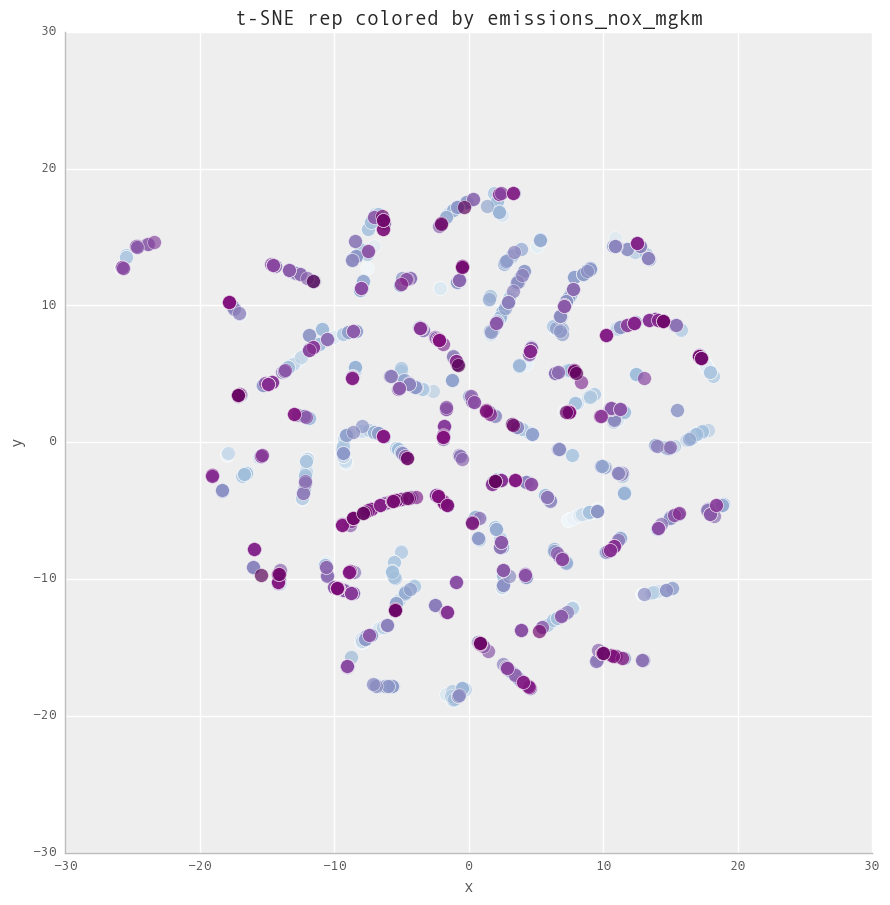

In [78]:
plot_tsne(dftsne, ft_num=fts_num+[ft_endog], ft_hue=ft_endog)

**Observe:**

+ The scale above ranges from light blue (low) to bright purple (high)
+ We see `emissions_nox_mgkm` is distributed slightly heterogenously throughout the space - with some clusters showing mostly high values, and some mostly low values
+ Again this indicates that a linear regression model might have some trouble fitting the data, but it's a good place to start before we try e.g. an SVM regression



# Parent - Manufacturer Hierarchy

Reminder of how the manufacturer ownership is structured: counts of cars (ows in the dataset) by manufacturer and parent group:

---
**Applied AI Ltd &copy; 2016**  
<a href='http://www.applied.ai'>applied.ai</a>